<a href="https://colab.research.google.com/github/err-aki/formation_pytorch/blob/main/Copy_of_10_Le_sous_et_le_sur_entrai%CC%82nement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Le sous et le sur entraînement

Les deux principaux défis que vous rencontrerez lors de votre parcours en data science sont le sous-entraînement et le sur-entraînement.

Votre modèle sera sous-entraîné s'il n'est pas assez complexe pour résoudre votre problème.

À l'inverse, un modèle sur-entraîné sera trop complexe pour votre problème. Il apprendra à mémoriser les données d'entraînement plutôt qu'à comprendre comment résoudre le problème de manière générale.

Dans ce notebook, nous explorerons des exemples de sous-entraînement et de sur-entraînement, et nous verrons comment surmonter ces problèmes.

## Problème à résoudre

Dans ce notebook on va tenter de créer un modèle capable de résoudre éfficacement le problème du jeu de données [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist). Le but est de prédire à quelle classe de vêtement chaque photo appartient. Nous avons 60 000 photos pour notre entraînement et 10 000 pour notre test. Ces images sont des photos de dimension 28x28 en intensité de gris.

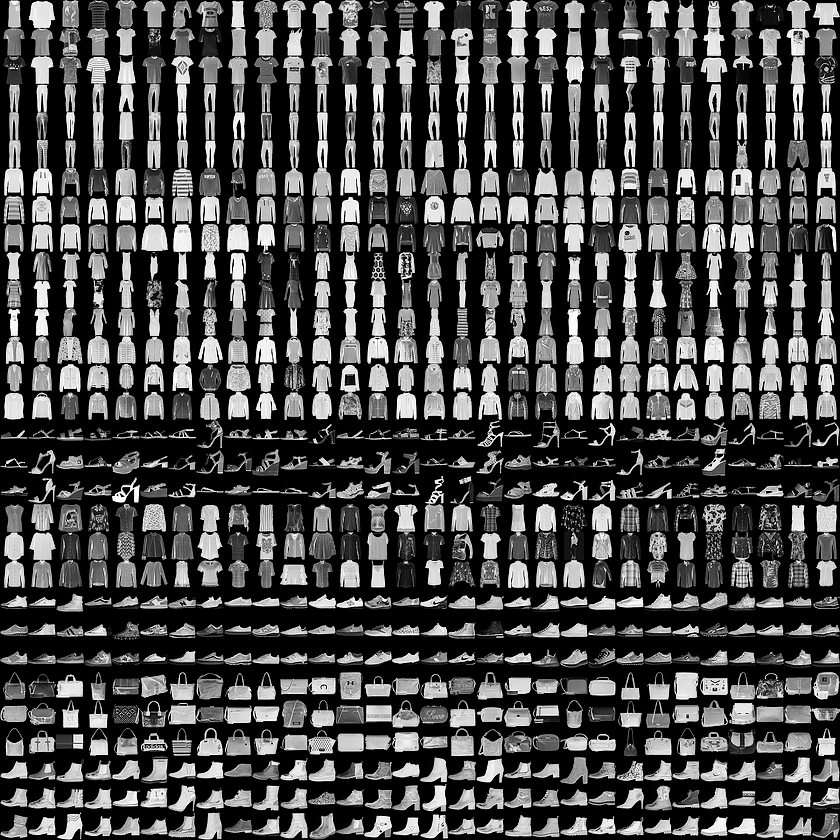

Ces photos appartiennent à 10 classes :
- les T-shirts ;
- les pantalons ;
- les pullover ;
- les robes ;
- les manteaux ;
- les sandales ;
- les chemises ;
- les baskettes ;
- les sacs ;
- les bottes.

## Importations des bibliothèques

Importons les bibliothèques dont nous allons avoir besoin dans ce notebook.

In [ ]:
import torch

from torchvision import datasets, transforms

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import numpy as np

from torch.utils.data import Subset

## Importations des données

Nous pouvons importer les images directement via PyTorch.

In [ ]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(0.5, 0.5)])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=2048, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=2048, shuffle=True)

# Visualisation d'une image

In [ ]:
x, y = next(iter(trainset))

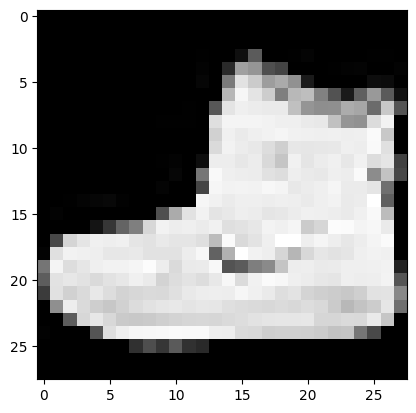

In [ ]:
# Show one of the images from the training dataset
plt.imshow(x[0, : ,:], cmap='Greys_r')
plt.show()

# Les fonctions d'entraînement

Métriques de performance

In [ ]:
def number_of_good_prediction(prediction:float, target:int):
  one_hot_prediction = np.argmax(prediction, axis=1)
  return np.sum(one_hot_prediction == target)

In [ ]:
def step(model:torch.nn.Sequential,
         opt:torch.optim,
         criterion:torch.nn.modules.loss,
         x_train:torch.Tensor,
         y_train:torch.Tensor,
         metric_function)->tuple:
  """
  Executes a single training step for a PyTorch model.
  This function performs a forward pass to compute the model's predictions, calculates
  the loss between predictions and actual target values, computes gradients for each
  model parameter, and updates the parameters using the optimizer.

  Args:
      model (torch.nn.Sequential): The PyTorch model to train.
      optimizer (torch.optim.Optimizer): Optimizer used to update the model's parameters.
      criterion (torch.nn.modules.loss._Loss): Loss function used to compute the error.
      x_train (torch.Tensor): Input training data (features).
      y_train (torch.Tensor): Ground truth labels or target values for the training data.
  Returns:
      tuple: The updated model and the computed loss for the current step.
  """

  # Réinitialisez les gradients d'optimizer à zéro avec la méthode 'zero_grad'
  optimizer.zero_grad()

  # Calculez les prédiction sur le jeu d'entraînement avec la méthode 'froward'
  prediction = model.forward(x_train)

  # Calculez l'erreur de prédiction avec 'criterion'
  loss = criterion(prediction, y_train)

  performance = metric_function(prediction.detach().numpy(), y_train.detach().numpy())

  # Calculez les gradients avec la méthode 'backward'
  loss.backward()

  # Mettre à jour les paramètres du modèle avec la méthode 'step'
  optimizer.step()

  return model, loss, performance

In [ ]:
def fit(model, optimizer, criterion, epoch, trainloader, testloader, metric_function):
    epoch = epoch
    history_train_loss = []
    history_test_loss = []
    history_train_metrics = []
    history_test_metrics = []

    for e in range(epoch) :

      train_loss_batch = 0
      test_loss_batch = 0
      train_metric_batch = 0
      test_metric_batch = 0

      for images, labels in trainloader:

        images = images.view(images.shape[0], -1)

        # mise à jour des poids avec la fonction 'step'
        model, train_loss, train_performance = step(model, optimizer, criterion, images, labels, metric_function)

        train_loss_batch += train_loss.detach().numpy()

        train_metric_batch += train_performance


      for images, labels in testloader:

        images = images.view(images.shape[0], -1)

        prediction = model.forward(images)

        test_loss = criterion(prediction, labels)

        test_metric_batch += metric_function(prediction.detach().numpy(), labels.detach().numpy())

        test_loss_batch += test_loss.detach().numpy()

      train_loss_batch /= len(trainloader.sampler)
      test_loss_batch /= len(testloader.sampler)

      train_metric_batch /= len(trainloader.sampler)
      test_metric_batch /= len(testloader.sampler)

      # Sauvegarde des coûts d'entraînement avec append
      history_train_loss = np.append(history_train_loss, train_loss_batch)
      history_test_loss = np.append(history_test_loss, test_loss_batch)

      # Sauvegarde des coûts d'entraînement avec append
      history_train_metrics = np.append(history_train_metrics, train_metric_batch)
      history_test_metrics = np.append(history_test_metrics, test_metric_batch)

      print('train_loss : '+str(np.squeeze(train_loss_batch))+ ' test_loss : '+str(np.squeeze(test_loss_batch)))
      print('train_metric : '+str(np.squeeze(train_metric_batch))+ ' test_metric : '+str(np.squeeze(test_metric_batch)))
      print('-------------------------------------------------------------------------------------------------')

    return model, history_train_loss, history_test_loss, history_train_metrics, history_test_metrics


## Le sous entraînement

## Initialisation de l'architecture

Initialisez un modèle avec :
- Une couche de neurones avec 784 données en entrée et 10 neurones.
- Une couche d'activation softmax.

In [ ]:
model = torch.nn.Sequential(torch.nn.Linear(784, 10),
                            torch.nn.LogSoftmax(dim=1))

Initialisez `criterion` avec la fonction `NLLLoss`.

Initialisez `optimizer` avec `Adam` et un learning rate de 0.001.

In [ ]:
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Vous allez commencer avec 5 epochs.

In [ ]:
epoch=5

Utilisez la fonction `fit` en appliquant les variables et la fonction initialisées précédemment.

In [ ]:
model, history_train_loss, history_test_loss, history_train_metrics, history_test = fit(model, optimizer, criterion, epoch, trainloader, testloader, number_of_good_prediction)

train_loss : 0.0005910862058401108 test_loss : 0.0003848497450351715
train_metric : 0.6126666666666667 test_metric : 0.7326
-------------------------------------------------------------------------------------------------
train_loss : 0.0003433364341656367 test_loss : 0.00032356755137443545
train_metric : 0.7649166666666667 test_metric : 0.7776
-------------------------------------------------------------------------------------------------
train_loss : 0.0003006434947252274 test_loss : 0.0002969578146934509
train_metric : 0.7956666666666666 test_metric : 0.7998
-------------------------------------------------------------------------------------------------
train_loss : 0.00027901974519093834 test_loss : 0.0002818886399269104
train_metric : 0.8112 test_metric : 0.8048
-------------------------------------------------------------------------------------------------
train_loss : 0.00026492232233285904 test_loss : 0.00027124993801116943
train_metric : 0.8203166666666667 test_metric : 0.8

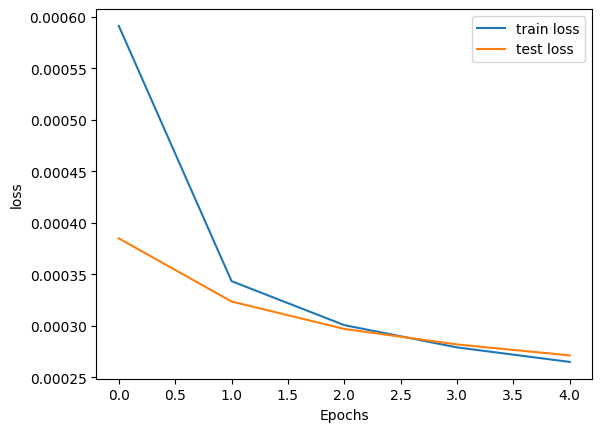

In [ ]:
plt.plot(np.arange(epoch), history_train_loss, label='train loss')
plt.plot(np.arange(epoch), history_test_loss, label='test loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend(loc='upper left')
plt.legend()
plt.show()

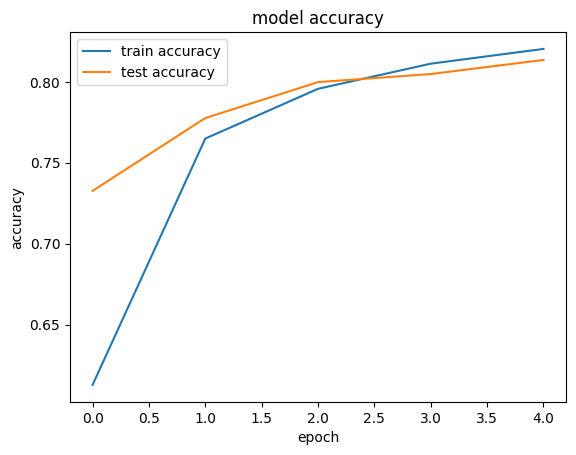

In [ ]:
plt.plot(history_train_metrics, label='train accuracy')
plt.plot(history_test, label='test accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

La loss et la performance du jeu d'entraînement et de test sont très proche les unes des autres sans être très haute. C'est de cette façon que l'on repère le sous apprentissage.

Deux options s'offre à nous :
- Augmenter la complexité du modèle,
- Continuer l'apprentissage,
- Changer le type de modèle.

**Augmentez le nombre d'epochs de votre modèle à 20**

In [ ]:
model = torch.nn.Sequential(torch.nn.Linear(784, 10),
                            torch.nn.LogSoftmax(dim=1))

Initialisez `criterion` avec la fonction `NLLLoss`.

Initialisez `optimizer` avec `Adam` et un learning rate de 0.001.

In [ ]:
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epoch_2=20

Utilisez la fonction `fit` en appliquant les variables et la fonction initialisées précédemment.  

Attention à bien utiliser `epoch_2`

In [ ]:
model, history_train_loss_2, history_test_loss_2, history_train_metrics_2, history_test_2 = fit(model, optimizer, criterion, epoch_2, trainloader, testloader, number_of_good_prediction)

train_loss : 0.0002539901907245318 test_loss : 0.00025877947211265566
train_metric : 0.8247166666666667 test_metric : 0.8136
-------------------------------------------------------------------------------------------------
train_loss : 0.00024068303058544794 test_loss : 0.0002505639374256134
train_metric : 0.8356 test_metric : 0.8226
-------------------------------------------------------------------------------------------------
train_loss : 0.0002329171116153399 test_loss : 0.00024648382365703584
train_metric : 0.8405166666666667 test_metric : 0.8248
-------------------------------------------------------------------------------------------------
train_loss : 0.0002277542327841123 test_loss : 0.00024202189445495604
train_metric : 0.8435666666666667 test_metric : 0.8309
-------------------------------------------------------------------------------------------------
train_loss : 0.00022379053930441539 test_loss : 0.00023833539187908173
train_metric : 0.847 test_metric : 0.8316
-------

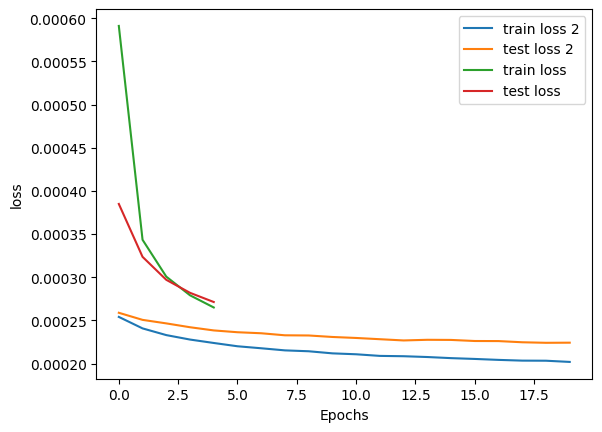

In [ ]:
plt.plot(np.arange(epoch_2), history_train_loss_2, label='train loss 2')
plt.plot(np.arange(epoch_2), history_test_loss_2, label='test loss 2')
plt.plot(np.arange(epoch), history_train_loss, label='train loss')
plt.plot(np.arange(epoch), history_test_loss, label='test loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend(loc='upper left')
plt.legend()
plt.show()

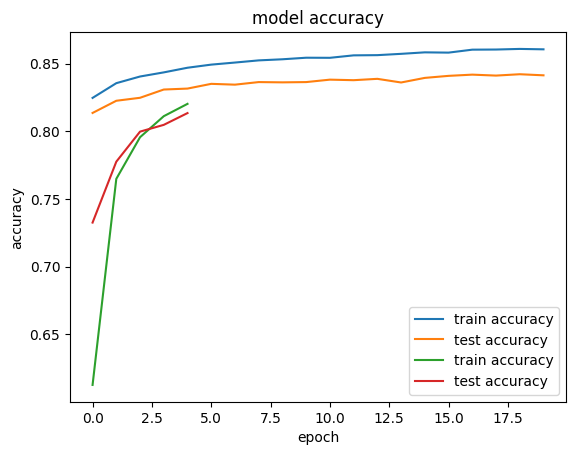

In [ ]:
plt.plot(history_train_metrics_2, label='train accuracy')
plt.plot(history_test_2, label='test accuracy')
plt.plot(history_train_metrics, label='train accuracy')
plt.plot(history_test, label='test accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()

**Augmentez la complexité du modèle**

Initialisez un modèle avec :
- Une couche cachée de 128 neurones (ReLU) ;
- Une couche cachée de 64 neurones (ReLU) ;
- Une couche de sortie avec 10 neurones et une fonction d'activation softmax.

In [ ]:
model = torch.nn.Sequential(torch.nn.Linear(784, 128),
                            torch.nn.ReLU() ,
                            torch.nn.Linear(128, 64),
                            torch.nn.ReLU() ,
                            torch.nn.Linear(64, 10),
                            torch.nn.LogSoftmax(dim=1))

Initialisez `criterion` avec la fonction `NLLLoss`.

Initialisez `optimizer` avec `Adam` et un learning rate de 0.001.

In [ ]:
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Utilisez la fonction `fit` en appliquant les variables et la fonction initialisées précédemment.

In [ ]:
model, history_train_loss_3, history_test_loss_3, history_train_metrics_3, history_test_3 =  fit(model, optimizer, criterion, epoch_2, trainloader, testloader, number_of_good_prediction)

train_loss : 0.0005995585938294728 test_loss : 0.0003315144062042236
train_metric : 0.6140333333333333 test_metric : 0.7557
-------------------------------------------------------------------------------------------------
train_loss : 0.000287926059961319 test_loss : 0.00027264493703842163
train_metric : 0.7899333333333334 test_metric : 0.8046
-------------------------------------------------------------------------------------------------
train_loss : 0.0002477731510996819 test_loss : 0.00025402399897575377
train_metric : 0.8228833333333333 test_metric : 0.8185
-------------------------------------------------------------------------------------------------
train_loss : 0.00022626270254453022 test_loss : 0.000235311758518219
train_metric : 0.83985 test_metric : 0.8353
-------------------------------------------------------------------------------------------------
train_loss : 0.00021420195202032725 test_loss : 0.00022440896928310394
train_metric : 0.8498166666666667 test_metric : 0.8

In [ ]:
epoch_3 = epoch_2

ValueError: x and y must have same first dimension, but have shapes (20,) and (5,)

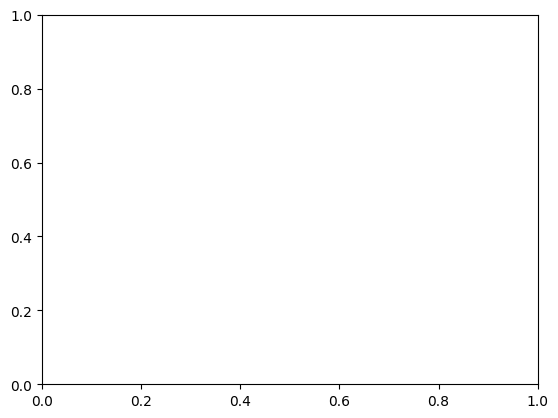

In [ ]:
plt.plot(np.arange(epoch_2), history_train_loss, label='train loss 1')
plt.plot(np.arange(epoch_2), history_test_loss, label='test loss 1')
plt.plot(np.arange(epoch_3), history_train_loss_3, label='train loss 3')
plt.plot(np.arange(epoch_3), history_test_loss_3, label='test loss 3')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend(loc='upper left')
plt.legend()
plt.show()

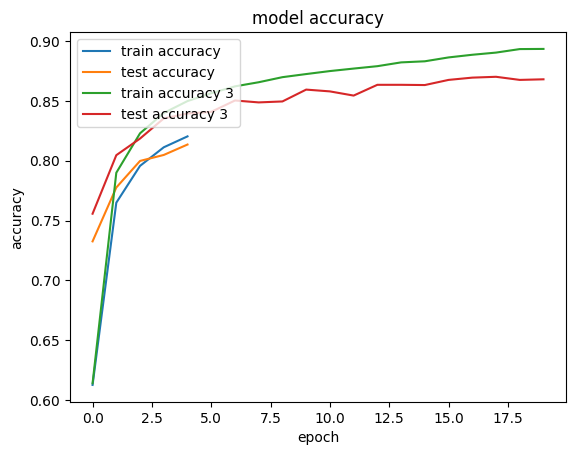

In [ ]:
plt.plot(history_train_metrics, label='train accuracy')
plt.plot(history_test, label='test accuracy')
plt.plot(history_train_metrics_3, label='train accuracy 3')
plt.plot(history_test_3, label='test accuracy 3')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

On peut voir que complexifier le modèle améliore les résultats du modèle.

Un autre moyen d'augmenter la performance de notre modèle serait d'utiliser une architecture spécifique aux traitements d'images comme le convolutional neural network.

# Le sur-entraînement

In [ ]:
model = torch.nn.Sequential(torch.nn.Linear(784, 256),
                            torch.nn.ReLU(),
                            torch.nn.Linear(256, 256),
                            torch.nn.ReLU(),
                            torch.nn.Linear(256, 256),
                            torch.nn.ReLU(),
                            torch.nn.Linear(256, 128),
                            torch.nn.ReLU(),
                            torch.nn.Linear(128, 128),
                            torch.nn.ReLU(),
                            torch.nn.Linear(128, 128),
                            torch.nn.ReLU(),
                            torch.nn.Linear(128, 64),
                            torch.nn.ReLU(),
                            torch.nn.Linear(64, 64),
                            torch.nn.ReLU(),
                            torch.nn.Linear(64, 64),
                            torch.nn.ReLU(),
                            torch.nn.Linear(64, 32),
                            torch.nn.ReLU(),
                            torch.nn.Linear(32, 32),
                            torch.nn.ReLU(),
                            torch.nn.Linear(32, 32),
                            torch.nn.ReLU(),
                            torch.nn.Linear(32, 10),
                            torch.nn.ReLU(),
                            torch.nn.Linear(10, 10),
                            torch.nn.ReLU(),
                            torch.nn.Linear(10, 10),
                            torch.nn.LogSoftmax(dim=1))

Initialisez `criterion` avec la fonction `NLLLoss`.

Initialisez `optimizer` avec `Adam` et un learning rate de 0.001.

In [ ]:
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epoch=40

In [ ]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(0.5, 0.5)])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader_few = torch.utils.data.DataLoader(Subset(trainset, range(5000)), batch_size=2048, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=2048, shuffle=True)

Utilisez la fonction `fit` en appliquant les variables et la fonction initialisées précédemment.

Attention à bien utiliser `trainloader_few` pour le jeu d'entraînement.

In [ ]:
model, history_train_loss, history_test_loss, history_train_metrics, history_test_metrics = fit(model, optimizer, criterion, epoch, trainloader_few, testloader, number_of_good_prediction)

train_loss : 0.0013933868408203124 test_loss : 0.0011586032390594483
train_metric : 0.0914 test_metric : 0.1
-------------------------------------------------------------------------------------------------
train_loss : 0.0013920725345611573 test_loss : 0.0011579366207122802
train_metric : 0.0914 test_metric : 0.1
-------------------------------------------------------------------------------------------------
train_loss : 0.0013924340724945068 test_loss : 0.001157235360145569
train_metric : 0.0914 test_metric : 0.1
-------------------------------------------------------------------------------------------------
train_loss : 0.0013904471397399901 test_loss : 0.0011563077211380005
train_metric : 0.0914 test_metric : 0.1
-------------------------------------------------------------------------------------------------
train_loss : 0.0013890812397003174 test_loss : 0.0011547139167785644
train_metric : 0.0914 test_metric : 0.1
----------------------------------------------------------------

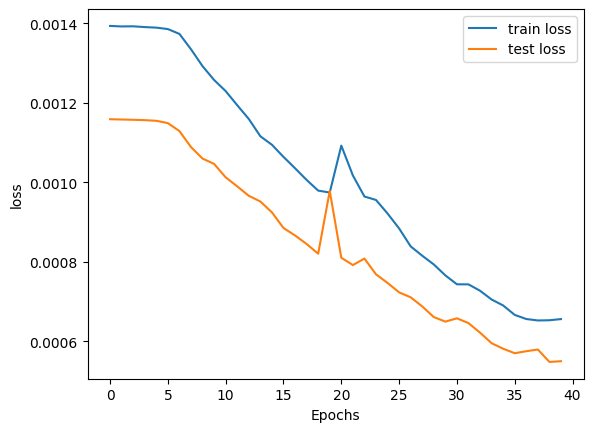

In [ ]:
plt.plot(np.arange(epoch), history_train_loss, label='train loss')
plt.plot(np.arange(epoch), history_test_loss, label='test loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend(loc='upper left')
plt.legend()
plt.show()

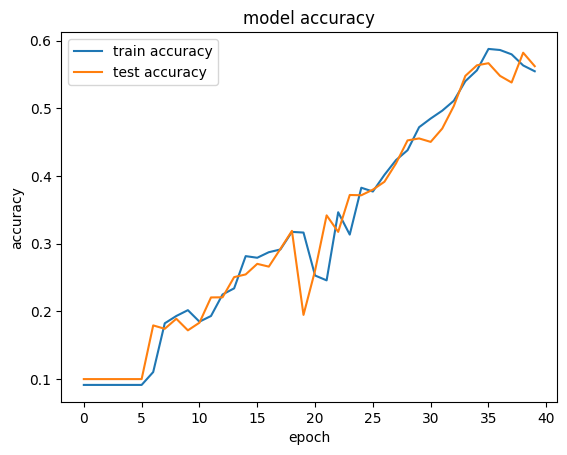

In [ ]:
plt.plot(history_train_metrics, label='train accuracy')
plt.plot(history_test_metrics, label='test accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

On voit ici une grande différence entre la performance sur le jeu d'entraînement et sur le jeu de test, c'est signe d'un sur-entraînement.

Plusieurs possibilités d'offrent à nous :
- Augmenter le nombre de données,
- Changer l'architecture du modèle,
- Simplifier l'architecture,
- Data augmentation,
- Régulariser le modèle.

## Simplifier le modèle

Initialisez un modèle avec :
- Une couche cachée de 512 neurones (ReLU) ;
- Une couche cachée de 256 neurones (ReLU) ;
- Une couche cachée de 128 neurones (ReLU) ;
- Une couche cachée de 64 neurones (ReLU) ;
- Une couche cachée de 32 neurones (ReLU) ;
- Une couche de sortie avec 10 neurones et une fonction d'activation softmax.

In [ ]:
model = torch.nn.Sequential(torch.nn.Linear(784, 512),
                            torch.nn.ReLU() ,
                            torch.nn.Linear(512, 256),
                            torch.nn.ReLU() ,
                            torch.nn.Linear(256, 128),
                            torch.nn.ReLU() ,
                            torch.nn.Linear(128, 64),
                            torch.nn.ReLU() ,
                            torch.nn.Linear(64, 32),
                            torch.nn.ReLU() ,
                            torch.nn.Linear(32, 10),
                            torch.nn.LogSoftmax(dim=1))

Initialisez `criterion` avec la fonction `NLLLoss`.

Initialisez `optimizer` avec `Adam` et un learning rate de 0.001.

In [ ]:
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Utilisez la fonction `fit` en appliquant les variables et la fonction initialisées précédemment.

Attention à bien utiliser `trainloader_few` pour le jeu d'entraînement.

In [ ]:
model, history_train_loss_2, history_test_loss_2, history_train_metrics_2, history_test_metrics_2 = fit(model, optimizer, criterion, epoch, trainloader_few, testloader, number_of_good_prediction)

train_loss : 0.0013787615776062012 test_loss : 0.0011359995603561401
train_metric : 0.0984 test_metric : 0.2346
-------------------------------------------------------------------------------------------------
train_loss : 0.0013434914588928222 test_loss : 0.0010805556058883668
train_metric : 0.3178 test_metric : 0.3376
-------------------------------------------------------------------------------------------------
train_loss : 0.0012485439777374268 test_loss : 0.0009554705142974854
train_metric : 0.3466 test_metric : 0.3484
-------------------------------------------------------------------------------------------------
train_loss : 0.0010811474084854126 test_loss : 0.0008141245722770691
train_metric : 0.3598 test_metric : 0.3762
-------------------------------------------------------------------------------------------------
train_loss : 0.0009062426805496216 test_loss : 0.0006862896800041198
train_metric : 0.3872 test_metric : 0.4563
------------------------------------------------

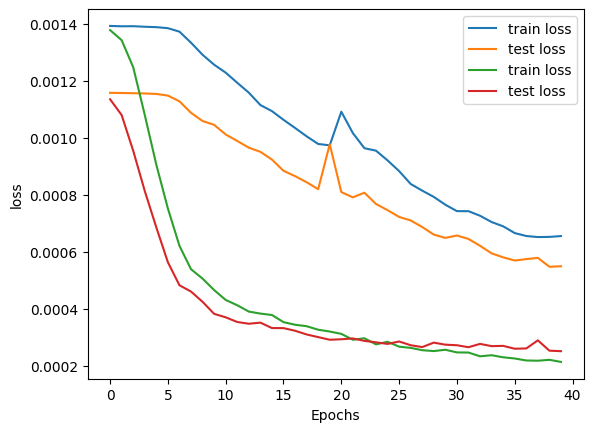

In [ ]:
plt.plot(np.arange(epoch), history_train_loss, label='train loss')
plt.plot(np.arange(epoch), history_test_loss, label='test loss')
plt.plot(np.arange(epoch), history_train_loss_2, label='train loss')
plt.plot(np.arange(epoch), history_test_loss_2, label='test loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend(loc='upper left')
plt.legend()
plt.show()

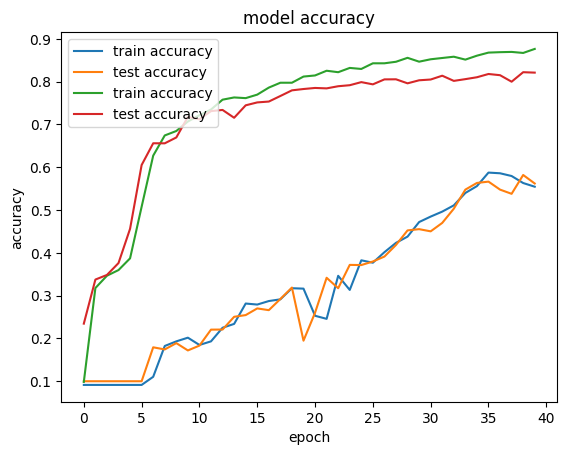

In [ ]:
plt.plot(history_train_metrics, label='train accuracy')
plt.plot(history_test_metrics, label='test accuracy')
plt.plot(history_train_metrics_2, label='train accuracy')
plt.plot(history_test_metrics_2, label='test accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

### Augmenter le nombre de données

Initialisez à nouveau le modèle et utilisez toutes les données disponibles.

In [ ]:
model = torch.nn.Sequential(torch.nn.Linear(784, 512),
                            torch.nn.ReLU() ,
                            torch.nn.Linear(512, 256),
                            torch.nn.ReLU() ,
                            torch.nn.Linear(256, 128),
                            torch.nn.ReLU() ,
                            torch.nn.Linear(128, 64),
                            torch.nn.ReLU() ,
                            torch.nn.Linear(64, 32),
                            torch.nn.ReLU() ,
                            torch.nn.Linear(32, 10),
                            torch.nn.LogSoftmax(dim=1))

Initialisez `criterion` avec la fonction `NLLLoss`.

Initialisez `optimizer` avec `Adam` et un learning rate de 0.001.

In [ ]:
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Utilisez la fonction `fit` en appliquant les variables et la fonction initialisées précédemment.

Attention à bien utiliser `trainloader` pour le jeu d'entraînement.

In [ ]:
model, history_train_loss_3, history_test_loss_3, history_train_metrics_3, history_test_metrics_3 = fit(model, optimizer, criterion, 20, trainloader, testloader, number_of_good_prediction)

train_loss : 0.0003317548513412476 test_loss : 0.00031014721393585204
train_metric : 0.7461 test_metric : 0.7668
-------------------------------------------------------------------------------------------------
train_loss : 0.00027574970374504725 test_loss : 0.0002800436317920685
train_metric : 0.7937 test_metric : 0.7936
-------------------------------------------------------------------------------------------------
train_loss : 0.0002472404390573502 test_loss : 0.00024937590956687926
train_metric : 0.8214 test_metric : 0.8209
-------------------------------------------------------------------------------------------------
train_loss : 0.00022299286077419916 test_loss : 0.00022869366109371186
train_metric : 0.8408833333333333 test_metric : 0.8396
-------------------------------------------------------------------------------------------------
train_loss : 0.0002060016229748726 test_loss : 0.00022530199587345124
train_metric : 0.85085 test_metric : 0.8392
-----------------------------

In [ ]:
plt.plot(np.arange(epoch), history_train_loss_2, label='train loss')
plt.plot(np.arange(epoch), history_test_loss_2, label='test loss')
plt.plot(np.arange(epoch), history_train_loss_3, label='train loss')
plt.plot(np.arange(epoch), history_test_loss_3, label='test loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend(loc='upper left')
plt.legend()
plt.show()

In [ ]:
plt.plot(history_train_metrics_2, label='train accuracy')
plt.plot(history_test_metrics_2, label='test accuracy')
plt.plot(history_train_metrics_3, label='train accuracy')
plt.plot(history_test_metrics_3, label='test accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

### Le drop out

Utilisez le drop out après chaque couche de votre modèle.

Aidez-vous de la [documentation](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html).

In [ ]:
model = torch.nn.Sequential(torch.nn.Linear(784, 512),
                            torch.nn.ReLU() ,
                            torch.nn.Linear(512, 256),
                            torch.nn.ReLU() ,
                            torch.nn.Linear(256, 128),
                            torch.nn.ReLU() ,
                            torch.nn.Linear(128, 64),
                            torch.nn.ReLU() ,
                            torch.nn.Linear(64, 32),
                            torch.nn.ReLU() ,
                            torch.nn.Linear(32, 10),
                            torch.nn.LogSoftmax(dim=1))

Initialisez `criterion` avec la fonction `NLLLoss`.

Initialisez `optimizer` avec `Adam` et un learning rate de 0.001.

In [ ]:
criterion = None
optimizer = None

Utilisez la fonction `fit` en appliquant les variables et la fonction initialisées précédemment.

In [ ]:
model, history_train_loss_4, history_test_loss_4, history_train_metrics_4, history_test_metrics_4 = None

In [ ]:
plt.plot(np.arange(epoch), history_train_loss_3, label='train loss')
plt.plot(np.arange(epoch), history_test_loss_3, label='test loss')
plt.plot(np.arange(epoch), history_train_loss_4, label='train loss')
plt.plot(np.arange(epoch), history_test_loss_4, label='test loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend(loc='upper left')
plt.legend()
plt.show()

In [ ]:
plt.plot(history_train_metrics_3, label='train accuracy')
plt.plot(history_test_metrics_3, label='test accuracy')
plt.plot(history_train_metrics_4, label='train accuracy')
plt.plot(history_test_metrics_4, label='test accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

On peut voir que l'erreur sur le jeu de test continue de descendre au lieu d'augmenter.